# Purpose

To reduce the size of the model while maintaining maximal information content, I will cluster all of the channels of each contact map and take a respresentative channel from each cluster.

In [1]:
# A little magic
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [67]:
# Imports
import h5py
from matplotlib import pyplot as plt
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.sparse import coo_matrix
import sklearn.cluster
import torch
import itertools
from tqdm import *

## Handle reading the HDF5 file containing all of the data

In [88]:
# Make a counts matrix to store co-clustering of 
counts = np.zeros((12, 12))

with h5py.File('../../data/contacts.hdf5', 'r') as h5file:
    keys = list(h5file.keys())
    for entry in tqdm(keys):
        atomtypes = h5file[entry]['memberships'][:]
        memberships = h5file[entry]['memberships'][:]
        target = torch.from_numpy(h5file[entry]['target'][:].astype(np.int64))
        target[:, 2] = target[:, 2] - 3
        
        n_res = np.max(memberships[:, 0]) + 1
        val = torch.ones(len(target))
        size = torch.Size([n_res, n_res, 12])
        
        contact_map = torch.sparse.FloatTensor(target.t(), val, size)
        contact_map = contact_map.to_dense().numpy().transpose((2, 0, 1)).reshape(12, -1)
        
        
        n_clust = 4
        clustering = sklearn.cluster.AgglomerativeClustering(n_clust).fit(contact_map)
        labels = clustering.labels_
        
        for i in range(n_clust):
            channels = np.where(labels == i)[0]
            for j in itertools.product(channels, repeat=2):
                counts[int(j[0]), int(j[1])] += 1

100%|██████████| 60895/60895 [3:31:54<00:00,  4.79it/s]


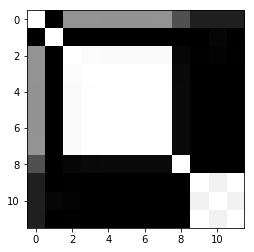

In [92]:
plt.imshow(counts / len(keys), cmap='gray')